In [1240]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from forecastingGDP.data import get_data,get_series_info
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.interpolate import interp1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

#### Data Retrieval

In [1206]:
FRED = Fred()

In [1207]:
SERIES = {
    'prod_indus':'INDPRO',
    'gdp':'GDPC1',
    #'Manufacturing Production'
    'BusinessExpectations':'ATLSBUSRGEP',
    'Capacity_Utilization':'TCU',
    #'manuf_ISM':'ISM'

    'Manufacturers_New_Orders':'AMTMNO',
    'New_Orders_Durable_Good':'DGORDER', #updated
    #'New_Orders_Non_defense_capital_good_ex_air':'NEWORDER',
    #'Building_permits'
    #'Housing_Starts'
    #'Construction Spending'
    #'new_car'
    #'Crude Oil Production'
    'Chicago_Fed_Activity_Index':'CFNAI',
    'University_of_Michigan_Consumer_Sentiment':'UMCSENT',
    #Philadelphia FedManufacturing Index

    'Advance_Retail_Sales':'MARTSMPCSM44000USS',
    'Real_Disposable_Personal_Income':'DSPIC96',
    'Personal_Consumption_Expenditure':'PCE',# old PCEC96

    #Initial Jobless Claims
    'Unemployment_Rate':'U1RATE',#old  UNRATE
    'Employment_Leve':'CE16OV',
    'Non_farm_payroll':'PAYEMS',
    'Not in Labor Force':'LNU05026648',

    #'Average Hourly Wages'
    'Consumer_Price_Index':'CPIAUCSL',
    'Personal_Consumption_Expenditure_ex_food':'PCEPILFE',
    'Producer_Price_Index':'PPIACO',
    #'Oil Price'
    #'Unit Labour Cost'
    # 'Imports_Goods_Services':'IEAMGSN',
    # 'Exports_Goods_Services':'IEAXGS',
    'Imports_Goods_Services':'IMPGSC1',#updated
    'Exports_Goods_Services':'EXPGSC1',#updated

    'Imports_Goods_from_China':'IMPCH',


    'BofA_US_High_Yield_Index':'BAMLH0A0HYM2',
    'S&P_500':'SP500',
    'Wilshire_5000_Market_Cap':'WILL5000INDFC',#updated  
    'VIX_Volatility':'VIXCLS',
    '10YUST':'GS10', # old DGS10
    '10YUST_2YUST':'GS2',#old T10Y2Y
    'US_Dollar Index':'DTWEXAFEGS',
}

SERIES_ID = list(SERIES.values())

OBSERVATION_START='1947-01-01'
AGGREGATION_METHOD = 'avg'
OUTPUT_TYPE_REALTIME = 1

In [1208]:
def get_freq(series_id):
    info=get_series_info(series_id)
    return info.frequency_short.lower()

In [1209]:
tab_freq=dict()

for serie_id in SERIES_ID:
    tab_freq[serie_id]=get_freq(serie_id)

In [1210]:
def get_series_with_freq(series_id,freq):
    '''Returns the series of ID `series_id` with a quarter frequency'''
    return FRED.get_series(
        series_id,
        frequency=freq,
        observation_start=OBSERVATION_START,
        aggregation_method=AGGREGATION_METHOD,
        output_type=OUTPUT_TYPE_REALTIME,
    )

In [1211]:
data=pd.DataFrame()
for serie_id in SERIES_ID :
    data[serie_id]=get_series_with_freq(serie_id,tab_freq[serie_id])

In [1212]:
data.shape

(893, 28)

In [1213]:
freq=[]
for i in SERIES_ID:
    freq.append(get_series_info(i))

In [1214]:
data_info=pd.DataFrame(freq)
data_info=data_info.set_index('id')

In [1215]:
data_info.columns

Index(['realtime_start', 'realtime_end', 'title', 'observation_start',
       'observation_end', 'frequency', 'frequency_short', 'units',
       'units_short', 'seasonal_adjustment', 'seasonal_adjustment_short',
       'last_updated', 'popularity', 'notes'],
      dtype='object')

#### Data Cleaning

In [1216]:
df=get_data()

In [1218]:
#Info and Missing Values %
percent_missing = df.isnull().sum() * 100 / len(data)
observation_start=data_info['observation_start']
observation_end=data_info['observation_end']
frequency=data_info['frequency_short']

df_info = pd.DataFrame({
                        'observation_start':observation_start,
                        'observation_end':observation_end,
                        'frequency':frequency,
                        'percent_missing': percent_missing})

df_info=df_info.sort_values('percent_missing',ascending=False)
df_info


,observation_start,observation_end,frequency,percent_missing
ATLSBUSRGEP,2016-12-01,2021-06-01,M,31.466965
SP500,2011-07-05,2021-07-02,D,29.003359
DTWEXAFEGS,2006-01-02,2021-06-25,D,26.539754
BAMLH0A0HYM2,1996-12-31,2021-07-01,D,22.508399
LNU05026648,1994-01-01,2021-06-01,M,21.164614
MARTSMPCSM44000USS,1992-02-01,2021-05-01,M,20.492721
AMTMNO,1992-02-01,2021-05-01,M,20.492721
DGORDER,1992-02-01,2021-05-01,M,20.380739
VIXCLS,1990-01-02,2021-07-01,D,19.372900
IMPCH,1985-01-01,2021-05-01,M,17.245241


In [1219]:
#Start from 1971-01 and end 2020-01 (for interpolation need)
for i in df_info.index:
    if int(df_info.loc[i]['observation_start'][:4])>=1971:
        data=data.drop(columns=[i])
        df_info=df_info.drop(i)


data=data.loc[data.index>='1971-01']
data=data.loc[data.index<='2020-01']
data.head()

,INDPRO,GDPC1,TCU,CFNAI,UMCSENT,DSPIC96,PCE,U1RATE,CE16OV,PAYEMS,CPIAUCSL,PCEPILFE,PPIACO,IMPGSC1,EXPGSC1,WILL5000INDFC,GS10
1971-01-01,37.7008,5069.746,79.7621,0.53,NaN,3735.8,676.1,1.3,78864.0,70865.0,39.9,22.747,37.3,280.390,205.434,NaN,6.24
1971-02-01,37.6290,NaN,79.4081,-0.02,78.1,3740.9,679.4,1.3,78700.0,70807.0,39.9,22.834,37.7,NaN,NaN,NaN,6.11
1971-03-01,37.5883,NaN,79.1210,-0.06,NaN,3753.2,682.0,1.3,78588.0,70860.0,40.0,22.907,37.8,NaN,NaN,NaN,5.70
1971-04-01,37.7993,5097.179,79.3641,0.45,NaN,3761.0,688.8,1.4,78987.0,71036.0,40.1,22.992,37.9,301.541,203.915,NaN,5.83
1971-05-01,37.9911,NaN,79.5656,0.41,80.2,3776.2,691.1,1.4,79139.0,71247.0,40.3,23.093,38.1,NaN,NaN,NaN,6.39


In [1220]:
#Info and Missing Values %
percent_missing = data.isnull().sum() * 100 / len(data)
observation_start=df_info['observation_start']
observation_end=df_info['observation_end']
frequency=df_info['frequency']

df_info = pd.DataFrame({
                        'observation_start':observation_start,
                        'observation_end':observation_end,
                        'frequency':frequency,
                        'percent_missing': percent_missing})

df_info=df_info.sort_values('percent_missing',ascending=False)
df_info=df_info.loc[df_info['observation_start']<'1971']
df_info


,observation_start,observation_end,frequency,percent_missing
EXPGSC1,1947-01-01,2021-01-01,Q,66.553480
GDPC1,1947-01-01,2021-01-01,Q,66.553480
IMPGSC1,1947-01-01,2021-01-01,Q,66.553480
WILL5000INDFC,1970-12-31,2021-07-01,D,48.217317
UMCSENT,1952-11-01,2021-05-01,M,9.507640
PCE,1959-01-01,2021-05-01,M,0.000000
U1RATE,1948-01-01,2021-06-01,M,0.000000
TCU,1967-01-01,2021-05-01,M,0.000000
PPIACO,1913-01-01,2021-05-01,M,0.000000
PCEPILFE,1959-01-01,2021-05-01,M,0.000000


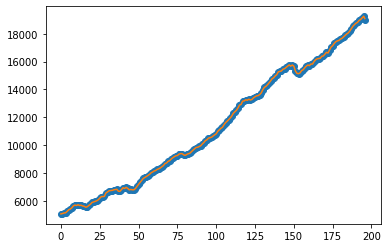

In [1221]:
#Interpolation test on GDPC1
X=np.arange(0, 197)
y=data['GDPC1'].dropna()
f = interp1d(X, y)
xnew = np.arange(0, 196, (1/3))
ynew = f(xnew)
plt.plot(X, y, 'o', xnew, ynew, '-')
plt.show()

In [1222]:
def interpolation():
    
    '''Create a linear interpolation of missing data'''
    for i in df_info.index:
        if df_info.loc[i]['frequency']=='Q':
            
            X=np.arange(0, len(data[i].dropna()))
            y=data[i].dropna()
            f = interp1d(X, y)
            xnew = np.arange(0, len(data[i].dropna())-1, (1/3))
            ynew = f(xnew)
            df_test.drop(columns=[i])
            df_test[i]=ynew
            
    return df_test

In [1223]:
#for interpolation purposes
df_test=data.copy()[:-1]

In [1224]:
df_m=interpolation()

In [1356]:
#Check interpolation 
for i in df_q.index:
    assert df_q.loc[i]['GDPC1']==df_q.loc[i]['GDPC1']

In [1225]:
df_m.head()

,INDPRO,GDPC1,TCU,CFNAI,UMCSENT,DSPIC96,PCE,U1RATE,CE16OV,PAYEMS,CPIAUCSL,PCEPILFE,PPIACO,IMPGSC1,EXPGSC1,WILL5000INDFC,GS10
1971-01-01,37.7008,5069.746000,79.7621,0.53,NaN,3735.8,676.1,1.3,78864.0,70865.0,39.9,22.747,37.3,280.390000,205.434000,NaN,6.24
1971-02-01,37.6290,5078.890333,79.4081,-0.02,78.1,3740.9,679.4,1.3,78700.0,70807.0,39.9,22.834,37.7,287.440333,204.927667,NaN,6.11
1971-03-01,37.5883,5088.034667,79.1210,-0.06,NaN,3753.2,682.0,1.3,78588.0,70860.0,40.0,22.907,37.8,294.490667,204.421333,NaN,5.70
1971-04-01,37.7993,5097.179000,79.3641,0.45,NaN,3761.0,688.8,1.4,78987.0,71036.0,40.1,22.992,37.9,301.541000,203.915000,NaN,5.83
1971-05-01,37.9911,5111.162000,79.5656,0.41,80.2,3776.2,691.1,1.4,79139.0,71247.0,40.3,23.093,38.1,303.763000,207.312667,NaN,6.39


In [1226]:
#Info and Missing Values %
percent_missing = df_m.isnull().sum() * 100 / len(df_m)
observation_start=df_info['observation_start']
observation_end=df_info['observation_end']
frequency=df_info['frequency']

df_info = pd.DataFrame({
                        'observation_start':observation_start,
                        'observation_end':observation_end,
                        'frequency':frequency,
                        'percent_missing': percent_missing})

df_info=df_info.sort_values('percent_missing',ascending=False)
df_info=df_info.loc[df_info['observation_start']<'1971']
df_info


,observation_start,observation_end,frequency,percent_missing
WILL5000INDFC,1970-12-31,2021-07-01,D,48.129252
UMCSENT,1952-11-01,2021-05-01,M,9.523810
PAYEMS,1939-01-01,2021-06-01,M,0.000000
U1RATE,1948-01-01,2021-06-01,M,0.000000
TCU,1967-01-01,2021-05-01,M,0.000000
PPIACO,1913-01-01,2021-05-01,M,0.000000
PCEPILFE,1959-01-01,2021-05-01,M,0.000000
PCE,1959-01-01,2021-05-01,M,0.000000
CE16OV,1948-01-01,2021-06-01,M,0.000000
CFNAI,1967-03-01,2021-05-01,M,0.000000


In [1227]:
#Starting and ending date
print(f'Start: {df_m.index[0]}')
print(f'End: {df_m.index[-1]}')
print(f'Shape: {df_m.shape}')

Start: 1971-01-01 00:00:00
End: 2019-12-01 00:00:00
Shape: (588, 17)


In [1229]:
list(df_m['UMCSENT'].index[df_m['UMCSENT'].apply(np.isnan)])

[Timestamp('1971-01-01 00:00:00'),
 Timestamp('1971-03-01 00:00:00'),
 Timestamp('1971-04-01 00:00:00'),
 Timestamp('1971-06-01 00:00:00'),
 Timestamp('1971-07-01 00:00:00'),
 Timestamp('1971-09-01 00:00:00'),
 Timestamp('1971-10-01 00:00:00'),
 Timestamp('1971-12-01 00:00:00'),
 Timestamp('1972-01-01 00:00:00'),
 Timestamp('1972-03-01 00:00:00'),
 Timestamp('1972-04-01 00:00:00'),
 Timestamp('1972-06-01 00:00:00'),
 Timestamp('1972-07-01 00:00:00'),
 Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-

In [1230]:
list(df_m['WILL5000INDFC'].index[df_m['WILL5000INDFC'].apply(np.isnan)])

[Timestamp('1971-01-01 00:00:00'),
 Timestamp('1971-02-01 00:00:00'),
 Timestamp('1971-03-01 00:00:00'),
 Timestamp('1971-04-01 00:00:00'),
 Timestamp('1971-05-01 00:00:00'),
 Timestamp('1971-06-01 00:00:00'),
 Timestamp('1971-07-01 00:00:00'),
 Timestamp('1971-08-01 00:00:00'),
 Timestamp('1971-09-01 00:00:00'),
 Timestamp('1971-10-01 00:00:00'),
 Timestamp('1971-11-01 00:00:00'),
 Timestamp('1971-12-01 00:00:00'),
 Timestamp('1972-01-01 00:00:00'),
 Timestamp('1972-02-01 00:00:00'),
 Timestamp('1972-03-01 00:00:00'),
 Timestamp('1972-04-01 00:00:00'),
 Timestamp('1972-05-01 00:00:00'),
 Timestamp('1972-06-01 00:00:00'),
 Timestamp('1972-07-01 00:00:00'),
 Timestamp('1972-08-01 00:00:00'),
 Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-

In [1235]:
df_m=df_m.drop(columns=['WILL5000INDFC','UMCSENT'])

In [1387]:
df=df_m

#### df_train & df_test split

In [1388]:
# Time Serie split 
#We separate df into df_train and df_test such that the first 80% of the dataframe are in the training. 
#And the last 20% in the test set.

len_ = int(0.6*df_m.shape[0])
df_train = df[:len_]
df_test = df[len_:len_+int(len(df[len_:])/2)]
df_val=df[len_+int(len(df[len_:])/2):]
assert df_train.shape[0]+df_test.shape[0]+df_val.shape[0] == df.shape[0]

In [1389]:
# Scale with MinMaxScale so they have the same range
columns = df.columns

scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_val=pd.DataFrame(scaler.transform(df_val), columns=columns)
df_train.head()

,INDPRO,GDPC1,TCU,CFNAI,DSPIC96,PCE,U1RATE,CE16OV,PAYEMS,CPIAUCSL,PCEPILFE,PPIACO,IMPGSC1,EXPGSC1,GS10
0,-1.513980,-1.464930,-0.557967,0.637600,-1.499964,-1.340489,-0.741153,-1.784798,-1.672026,-1.601482,-1.605268,-2.044332,-1.085056,-1.162302,-0.877920
1,-1.519263,-1.460742,-0.662379,-0.189797,-1.496631,-1.338559,-0.741153,-1.795042,-1.675504,-1.601482,-1.600616,-2.030190,-1.067608,-1.163843,-0.934363
2,-1.522258,-1.456554,-0.747059,-0.249971,-1.488594,-1.337038,-0.741153,-1.802038,-1.672326,-1.599032,-1.596714,-2.026654,-1.050160,-1.165384,-1.112377
3,-1.506732,-1.452366,-0.675357,0.517251,-1.483497,-1.333060,-0.599058,-1.777114,-1.661773,-1.596582,-1.592169,-2.023119,-1.032711,-1.166925,-1.055934
4,-1.492619,-1.445962,-0.615925,0.457077,-1.473564,-1.331715,-0.599058,-1.767619,-1.649120,-1.591681,-1.586769,-2.016047,-1.027213,-1.156585,-0.812793


In [1390]:
df_train.shape

(352, 15)

In [1391]:
df_test.shape

(118, 15)

In [1392]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample


def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['GDPC1']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [1393]:
#Sequences has to be >100 for our model to train correctly
X_train, y_train = get_X_y(df_train, 500, 4)
print(X_train.shape)
print(y_train.shape)

(500, 3, 15)
(500,)


In [1394]:
X_test, y_test = get_X_y(df_test, 50, 4)
print(X_test.shape)
print(y_test.shape)

(50, 3, 15)
(50,)


In [1395]:
X_val, y_val = get_X_y(df_val, 50, 4)
print(X_val.shape)
print(y_val.shape)

(50, 3, 15)
(50,)


In [1396]:
input_shape=X_train[0].shape

### RNN MODEL

In [1397]:
# Mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : 98.38 %


In [1398]:
# Predict MAPE with last GDP value
y_pred_baseline = X_test[:,-1,1]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

Benchmark MAPE on the test set : 0.54 %


In [1399]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline-y_test))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

Benchmark MAE on the test set : 2.8390


In [1400]:
# Predict MAE with last GDP value
y_pred_baseline = X_test[:,-1,1]
bench_res = np.mean(np.abs(y_pred_baseline - y_test))
print(f'Benchmark MAE on the test set : {bench_res:.2f} %')

Benchmark MAE on the test set : 0.02 %


In [1401]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

Benchmark RMSE on the test set : 2.8699


In [1402]:
# Predict RMSE with last GDP value
y_pred_baseline = X_test[:,-1,1]
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

Benchmark RMSE on the test set : 0.0190


In [1403]:
input_shape=X_train.shape[1:]
input_shape

(3, 15)

In [1411]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.LSTM(50, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop', 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 3, 50)             13200     
_________________________________________________________________
lstm_69 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 6         
Total params: 18,991
Trainable params: 18,991
Non-trainable params: 0
_________________________________________________________________


In [1412]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=10,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=16,
            verbose=0,
            callbacks=[es])

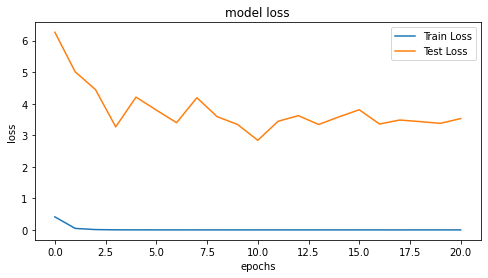

In [1413]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [1414]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.4303
MAPE on the test set: 13.8045
RMSE on the test set: 0.6559


In [1415]:
y_pred=model.predict(X_test)

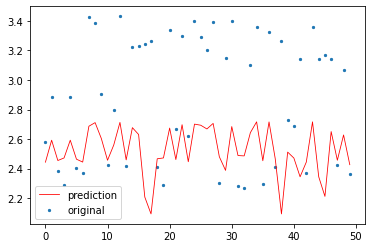

In [1416]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()

In [1328]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.GRU(20, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.GRU(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 3, 20)             2220      
_________________________________________________________________
gru_5 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense_58 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 6         
Total params: 3,241
Trainable params: 3,241
Non-trainable params: 0
_________________________________________________________________


In [1329]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=10,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=32,
            verbose=0,
            callbacks=[es])

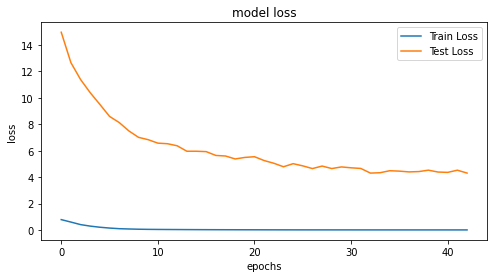

In [1330]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [1331]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.6913
MAPE on the test set: 23.0373
RMSE on the test set: 0.8314


In [1332]:
y_pred=model.predict(X_test)

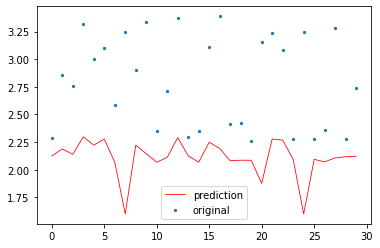

In [1333]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()